In [ ]:
# Code for Modern Tensorflow 2 with Keras for CNNs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

In [ ]:
# --- 1. Data Loading and Preprocessing (Modernized) ---

# Define the base path to your dataset
DATA_DIR = 'data/room_dataset'

# Get the list of room types (class names) from the directory names
try:                    # os.listdir => only returns unique names of directories
    room_types = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
except FileNotFoundError:
    print(f"Error: The directory '{DATA_DIR}' was not found.")
    print("Please make sure your data is in a folder named 'data/room_dataset' relative to the notebook.")
    # Create dummy data to allow the rest of the script to run for demonstration
    room_types = ['bed_room', 'dining_room', 'living_room']
    print("Using dummy class names for demonstration.")


print(f"Room types found: {room_types}")
print(f"Number of classes: {len(room_types)}\n")

Room types found: ['bed_room', 'dining_room', 'living_room']
Number of classes: 3



In [3]:
images = []
labels = []

# Loop through each room type folder
for room_type in room_types:
    class_path = os.path.join(DATA_DIR, room_type)
    
    # Check if the path exists to avoid errors
    if not os.path.isdir(class_path):
        print(f"Warning: Directory for class '{room_type}' not found. Skipping.")
        continue
        
    for image_filename in os.listdir(class_path):
        # Construct the full image path
        img_path = os.path.join(class_path, image_filename)
        try:
            # Read the image using OpenCV
            img = cv2.imread(img_path)
            # OpenCV reads images in BGR format, convert it to RGB for consistency
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize the image to a fixed size (60x60 pixels)
            img = cv2.resize(img, (60, 60))
            
            images.append(img)
            labels.append(room_type)
        except Exception as e:
            print(f"Error loading or processing image {img_path}: {e}")

In [5]:
# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize pixel values from [0, 255] to [0.0, 1.0]
images = images / 255.0

print(f"\nLoaded {len(images)} images.")
print(f"Shape of images array: {images.shape}")


Loaded 47 images.
Shape of images array: (47, 60, 60, 3)


In [ ]:
# --- 2. Label Encoding (Modernized) ---

# Use LabelEncoder to convert string labels ('bed_room', etc.) to integers (0, 1, 2)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# One-hot encode the integer labels for use with categorical_crossentropy
# e.g., 2 -> [0, 1, 0]
one_hot_labels = to_categorical(integer_labels)

num_classes = len(room_types)
print(f"Shape of one-hot encoded labels array: {one_hot_labels.shape}")

Shape of one-hot encoded labels array: (47, 3)


In [7]:
# --- 3. Data Splitting ---

# Split the data into training and testing sets (90% train, 10% test)
# stratify=integer_labels ensures that the class distribution is similar in both sets
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    one_hot_labels, 
    test_size=0.1, 
    random_state=42,
    stratify=integer_labels
)

print(f"\nTraining data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training data shape: (42, 60, 60, 3), Training labels shape: (42, 3)
Testing data shape: (5, 60, 60, 3), Testing labels shape: (5, 3)


In [8]:
# --- 4. Model Definition (Modernized with Keras Sequential API) ---

# Define the model architecture layer by layer
model = Sequential([
    # Define the input shape for the first layer
    Input(shape=(60, 60, 3)),

    # Convolutional Layer 1
    # 32 filters, 5x5 kernel, 'same' padding to keep dimensions, ReLU activation
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2
    # 64 filters, 5x5 kernel
    Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 3
    # 128 filters, 5x5 kernel
    Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the 3D feature maps into a 1D vector
    Flatten(),

    # Fully Connected (Dense) Layer
    # 2048 neurons
    Dense(2048, activation='relu'),

    # Output Layer
    # 'num_classes' neurons (one for each room type)
    # 'softmax' activation for multi-class probability distribution
    Dense(num_classes, activation='softmax')
])

In [9]:
# --- 5. Model Compilation ---

# Configure the model for training
model.compile(
    optimizer='adam',  # Adam optimizer is a good default choice
    loss='categorical_crossentropy',  # Use for one-hot encoded labels
    metrics=['accuracy']  # Track accuracy during training
)

# Print a summary of the model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    12,847,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,111,875 (50.02 MB)

 Trainable params: 13,111,875 (50.02 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- 6. Model Training (Modernized) ---

print("\nStarting model training...")

# Define hyperparameters
EPOCHS = 25  # Increased epochs for better training
BATCH_SIZE = 8 # Smaller batch size for small datasets

# Train the model using the .fit() method
history = model.fit(
    X_train, 
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test) # Provide validation data to monitor performance
)

print("\nTraining finished.")


Starting model training...
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.3776 - loss: 1.1214 - val_accuracy: 0.6000 - val_loss: 1.0384
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5601 - loss: 1.0477 - val_accuracy: 0.6000 - val_loss: 0.9731
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5125 - loss: 1.0365 - val_accuracy: 0.6000 - val_loss: 1.0214
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4479 - loss: 1.0790 - val_accuracy: 0.6000 - val_loss: 1.0317
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5158 - loss: 1.0549 - val_accuracy: 0.6000 - val_loss: 0.9857
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5298 - loss: 1.0327 - val_accuracy: 0.6000 - val_loss: 0.9525
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4086 - loss: 1.1346 - val_accuracy: 0.6000 - val_loss: 0.9640
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4658 - loss: 1.0712 - val_

In [11]:
# --- 7. Model Evaluation (Modernized) ---

print("\nEvaluating model on the test set...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


Evaluating model on the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6000 - loss: 0.9515
Test Loss: 0.9515
Test Accuracy: 60.00%


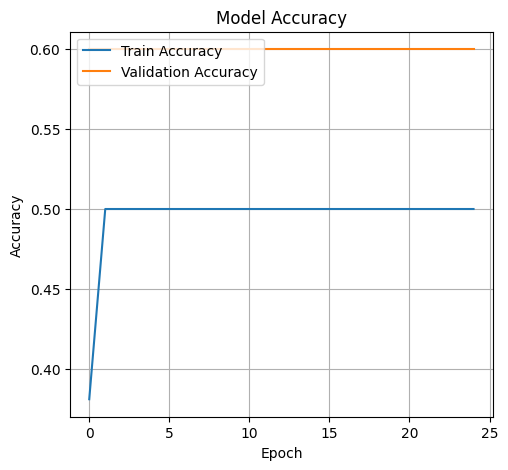

In [12]:
# --- 8. Plotting Training History ---

# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

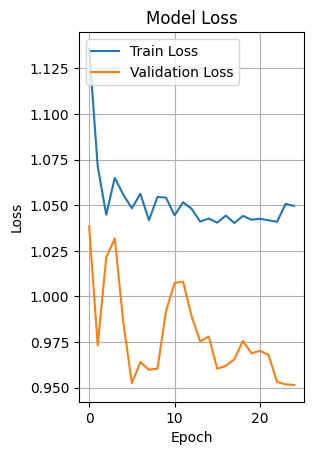

In [13]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()